In [1]:
import numpy as np
import pandas as pd
import mlflow
import warnings
import pickle
import sys, os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [2]:
# sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler

# Preprocessing

In [4]:
file_handler = FileHandler()
# reading the csv file
credit_df = file_handler.read_csv("../data/creditcard.csv")


In [5]:
data = credit_df.groupby("Time").agg({"Class": "mean"})
data

Class
Time           
0.0         0.0
1.0         0.0
2.0         0.0
4.0         0.0
7.0         0.0
...         ...
172785.0    0.0
172786.0    0.0
172787.0    0.0
172788.0    0.0
172792.0    0.0

[124592 rows x 1 columns]

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

In [7]:
data

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [8]:
##splitting dataset into train and test split
training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:1]

In [9]:
training_size,test_size

(80984, 43608)

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
import numpy
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
print(X_train.shape), print(y_train.shape)

(80883, 100)
(80883,)


(None, None)

In [13]:
print(X_test.shape), print(ytest.shape)

(43507, 100)
(43507,)


(None, None)

In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


 333/1264 ━━━━━━━━━━━━━━━━━━━━ 1:25 78ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 78ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 78ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 78ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 78ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 78ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 78ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 78ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 78ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:25 79ms/step - loss: 0.00 ━━━━━━━━━━

 500/1264 ━━━━━━━━━━━━━━━━━━━━ 1:15 81ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 81ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 81ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 82ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 83ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 83ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 83ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 83ms/step - loss: 0.00 ━━━━━━━━━━

 667/1264 ━━━━━━━━━━━━━━━━━━━━ 1:05 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:05 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:05 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:05 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:05 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:05 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:05 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - loss: 0.00 ━━━━━━━━━━

 834/1264 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 50s 88ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 50s 88ms/step - loss: 0.001 ━━━━━━━━━━

1001/1264 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - loss: 0.001 ━━━━━━━━━━

1169/1264 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.001 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.00 ━━━

 163/1264 ━━━━━━━━━━━━━━━━━━━━ 3:01 144ms/step - loss: 3.4245e-0 ━━━━━━━━━━━━━━━━━━━━ 1:42 81ms/step - loss: 3.5737e-0 ━━━━━━━━━━━━━━━━━━━━ 2:00 95ms/step - loss: 3.5756e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 3.5466e- ━━━━━━━━━━━━━━━━━━━━ 2:00 95ms/step - loss: 3.4835e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 4.2390e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 6.5831e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 8.0368e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 2.8167e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 4.2393e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 5.8827e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 7.0975e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 9.0266e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.0011   ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 

 330/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 99ms/step - lo

 497/1264 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:28 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:28 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:28 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:28 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:28 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:28 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:28 97ms/step - loss: 0.00 ━━━━━━━━━━

 664/1264 ━━━━━━━━━━━━━━━━━━━━ 1:13 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:13 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:13 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:13 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:13 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:12 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:11 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:11 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:11 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:11 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:11 96ms/step - loss: 0.00 ━━━━━━━━━━

 831/1264 ━━━━━━━━━━━━━━━━━━━━ 57s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 57s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 57s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 57s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 57s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 57s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 56s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 55s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 55s 96ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 55s 96ms/step - loss: 0.001 ━━━━━━━━━━

 998/1264 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 0.00 ━━━━━━━━━━

1165/1264 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0016 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.001 ━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:23 161ms/step - loss: 3.2356e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 9.7447e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━

 322/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:01 112ms/step - loss: 0.002 

 482/1264━━━━━━ 2:14 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 142ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 141ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 141ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 141ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 141ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 141ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 141ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 141ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:09 141ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:41 130ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 130ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 130ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 130ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 129ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 805/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 122ms/step - loss: 0.001 ━━━━━

 972/1264 ━━━━━━━━━━━━━━━━━━━━ 54s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - loss: 0.00 ━━━━━━━━━━

1139/1264 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.00 ━━━━━━━━━━

 155/1264 ━━━━━━━━━━━━━━━━━━━━ 2:55 139ms/step - loss: 1.1025e-0 ━━━━━━━━━━━━━━━━━━━━ 1:49 87ms/step - loss: 1.0099e-0 ━━━━━━━━━━━━━━━━━━━━ 1:53 90ms/step - loss: 1.0818e- ━━━━━━━━━━━━━━━━━━━━ 1:53 90ms/step - loss: 1.0703e- ━━━━━━━━━━━━━━━━━━━━ 1:54 91ms/step - loss: 4.8711e- ━━━━━━━━━━━━━━━━━━━━ 1:54 91ms/step - loss: 6.8480e- ━━━━━━━━━━━━━━━━━━━━ 1:52 89ms/step - loss: 7.9209e- ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 9.1841e- ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 9.9468e- ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 1.0398e- ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 1.0648e- ━━━━━━━━━━━━━━━━━━━━ 1:55 93ms/step - loss: 1.0767e- ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 1.0797e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 1.0768e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 1.0698e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 1.0601e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 1.0483e- ━━━━━━━━━━━━━━━━━━━━ 1:56 94ms/step - loss: 1.0353e- ━━━━━━━━━━━━━━━━━━━━ 1:56 94ms/st

 322/1264 ━━━━━━━━━━━━━━━━━━━━ 1:46 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━

 489/1264 ━━━━━━━━━━━━━━━━━━━━ 1:31 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 97ms/step - loss: 0.00 ━━━━━━━━━━

 656/1264 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:14 98ms/step - loss: 0.00 ━━━━━━━━━━

 823/1264 ━━━━━━━━━━━━━━━━━━━━ 1:00 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:00 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:00 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.0015 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━

 990/1264 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.001 ━━━━━━━━━━

1157/1264 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - loss: 0.001 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - l

 149/1264 ━━━━━━━━━━━━━━━━━━━━ 3:17 156ms/step - loss: 3.1511e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 107ms/step - loss: 2.8185e-0 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 2.4457e-0 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 2.1581e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 112ms/step - loss: 1.9396e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 1.8180e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 1.7106e-0 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 4.3326e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 6.1080e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 9.0609e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 1.1187e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 1.2733e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 1.3891e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 1.4742e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 1.5364e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 1.5815e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 1.6136e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 1.6356e-0 

 309/1264 ━━━━━━━━━━━━━━━━━━━━ 2:15 121ms/step - loss: 9.8592e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 121ms/step - loss: 9.8869e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 121ms/step - loss: 9.9136e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 121ms/step - loss: 9.9394e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 121ms/step - loss: 9.9643e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 121ms/step - loss: 9.9883e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 121ms/step - loss: 0.0010    ━━━━━━━━━━━━━━━━━━━━ 2:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 120ms/step - loss:

 470/1264 ━━━━━━━━━━━━━━━━━━━━ 1:50 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 631/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 114ms/step - loss: 0.001 ━━━━━

 793/1264━━ 1:12 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:12 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - l

 960/1264 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 114ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━

1127/1264 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━

 164/1264 ━━━━━━━━━━━━━━━━━━━━ 3:06 148ms/step - loss: 1.3006e-0 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 1.3890e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 0.0017   ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 

 325/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 102ms/step - loss: 0.001 

 485/1264━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step

 646/1264 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 812/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━

 979/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - lo

1146/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:04 146ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 322/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 114ms/step - loss: 0.001 ━━━━━

 483/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 

 643/1264━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 110ms/step -

 808/1264 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 975/126449s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/s

1142/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━

 149/1264 ━━━━━━━━━━━━━━━━━━━━ 2:53 137ms/step - loss: 1.1948e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 1.3906e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 1.6260e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 1.7455e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 1.9607e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 2.1406e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 3.2402e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 5.3036e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 6.6650e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 7.5812e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 8.2002e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 8.6163e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 8.8905e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 9.0637e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 9.1638e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 9.2103e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 9.2189e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 9.1978e-0 ━

 306/1264 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 9.2254e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 9.2474e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 9.2687e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.2891e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.3088e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.3276e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.3458e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.3632e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.3799e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.3963e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.4136e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.4301e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.4461e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.4613e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 9.4818e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 9.5025e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 9.5225e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 9.5418e-0 

 467/1264 ━━━━━━━━━━━━━━━━━━━━ 1:47 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 628/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━

 791/1264━━ 1:09 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - l

 958/1264 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━

1125/1264 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:58 141ms/step - loss: 0.015 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 0.012 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 0.010 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2

 322/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 107ms/step - loss: 0.001 ━━━━━

 483/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 

 643/1264━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step -

 807/1264 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 974/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/step - loss: 0.00 ━━━━━━━━━━

1141/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.00 ━━━━━━━━━━

 149/1264 ━━━━━━━━━━━━━━━━━━━━ 3:04 146ms/step - loss: 1.4576e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 1.1050e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 2.6728e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 7.0245e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 8.8453e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 9.6205e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 9.9022e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 9.9402e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 9.8463e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 9.6826e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 9.4827e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 9.2656e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 9.0428e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 8.8240e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 8.6085e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 8.3987e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 8.2036e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 8.0298e-0 ━

 306/1264 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.6182e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.6481e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.6838e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.7188e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.7532e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.7865e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.8189e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.8503e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.8808e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.9105e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.9392e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.9670e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.9940e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 9.0202e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 9.0513e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 9.0816e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 9.1111e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 9.1396e-0 

 467/1264 ━━━━━━━━━━━━━━━━━━━━ 1:41 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 628/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━

 792/1264━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - l

 959/126450s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/s

1126/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━

 159/1264 ━━━━━━━━━━━━━━━━━━━━ 2:56 139ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 98ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 8.9888e- ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 8.5775e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 8.1125e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 7.6782e- ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 7.2735e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 6.9041e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 6.5692e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 6.2658e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 6.3811e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 6.4334e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 6.4423e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 6.4211e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 6.3787e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 6.8617e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 7.2983e-0 ━━━━━━━━━━━━━━━━━━━━

 320/1264 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 481/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━

 641/1264━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 110ms/step -

 805/1264 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 972/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━

1139/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━

 156/1264 ━━━━━━━━━━━━━━━━━━━━ 3:00 143ms/step - loss: 2.7467e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 3.1947e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 3.2163e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 3.1897e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 3.1352e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 3.0626e- ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 2.9862e- ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 2.9130e- ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 2.8349e- ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.7529e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 2.6720e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.5953e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.5530e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.5074e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.4602e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 3.0980e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 3.6181e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 4.5864e-0 ━━━━━━━━━━━━━━━

 317/1264 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 478/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━

 638/1264━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step -

 803/1264 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 970/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - lo

1137/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━

 159/1264 ━━━━━━━━━━━━━━━━━━━━ 3:14 154ms/step - loss: 8.1937e-0 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - loss: 8.1648e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 112ms/step - loss: 7.5690e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 115ms/step - loss: 9.6829e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 116ms/step - loss: 1.0361e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 116ms/step - loss: 1.0535e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 1.0486e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 119ms/step - loss: 1.0301e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 1.0051e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 1.3639e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 1.6198e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 119ms/step - loss: 1.8073e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 120ms/step - loss: 2.8599e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 3.6837e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 120ms/step - loss: 4.3551e-0 ━━━━━━━━━━━━━━━━━━━━ 2:30 121ms/step - loss: 4.8890e-0 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 5.3156e-0 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 5.7772e-0 

 320/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.002 

 480/1264━━━━━━ 1:45 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step

 641/1264 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:24 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:24 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 805/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.002 ━━━━━

 972/126451s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/s

1139/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.00 ━━━━━━━━━━

 162/1264 ━━━━━━━━━━━━━━━━━━━━ 3:00 143ms/step - loss: 5.1097e-0 ━━━━━━━━━━━━━━━━━━━━ 1:54 91ms/step - loss: 5.1312e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 5.4942e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 5.5770e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 5.5828e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 4.3805e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 6.9404e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 8.5127e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.0011   ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━

 323/1264 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 484/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━

 644/1264━━━━ 1:23 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step -

 809/1264 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 976/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 

1143/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.00 ━━━━━━━━━━

 163/1264 ━━━━━━━━━━━━━━━━━━━━ 2:55 139ms/step - loss: 1.9658e-0 ━━━━━━━━━━━━━━━━━━━━ 2:00 95ms/step - loss: 0.0039    ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00

 324/1264 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 485/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step - loss: 0.001 ━━━━━

 645/1264━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step -

 811/1264 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 978/126447s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/s

1145/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:34 170ms/step - loss: 0.014 ━━━━━━━━━━━━━━━━━━━━ 2:30 119ms/step - loss: 0.010 ━━━━━━━━━━━━━━━━━━━━ 2:26 116ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:32 122ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:32 122ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:31 122ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:31 122ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:31 122ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:32 122ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 

 322/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 119ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 119ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 119ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 119ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 118ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 117ms/step - loss: 0.002 ━━━━━

 483/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 113ms/step - loss: 0.002 

 643/1264━━━━ 1:27 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:24 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:24 111ms/step -

 807/1264 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:10 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 974/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - lo

1141/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.00 ━━━━━━━━━━

 156/1264 ━━━━━━━━━━━━━━━━━━━━ 2:47 133ms/step - loss: 2.3700e-0 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 2.4677e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.5952e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 1.3182e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 1.7862e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.0051e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.1033e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 2.1436e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 2.1470e- ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 2.1296e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.3199e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 2.4495e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 3.4578e- ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 4.2429e- ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 4.8592e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 5.3467e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 5.7332e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 6.0426e-0 ━━━━━━━━━━

 317/1264 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 478/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━

 638/1264━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step -

 803/1264 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 970/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━

1137/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:58 141ms/step - loss: 1.0585e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 110ms/step - loss: 9.7703e-0 ━━━━━━━━━━━━━━━━━━━━ 2:22 113ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 9.5749e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.0012    ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.002 ━

 322/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 103ms/step - loss: 0.001 

 482/1264━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 152/1264 ━━━━━━━━━━━━━━━━━━━━ 3:15 155ms/step - loss: 3.3471e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 115ms/step - loss: 3.3162e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 116ms/step - loss: 3.3278e-0 ━━━━━━━━━━━━━━━━━━━━ 2:25 115ms/step - loss: 3.2924e-0 ━━━━━━━━━━━━━━━━━━━━ 2:22 113ms/step - loss: 3.2345e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 112ms/step - loss: 3.1690e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 112ms/step - loss: 3.0910e-0 ━━━━━━━━━━━━━━━━━━━━ 2:22 113ms/step - loss: 3.6594e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - loss: 4.0214e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - loss: 4.2452e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - loss: 4.3835e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - loss: 4.4858e-0 ━━━━━━━━━━━━━━━━━━━━ 2:22 114ms/step - loss: 4.5395e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 114ms/step - loss: 4.5605e-0 ━━━━━━━━━━━━━━━━━━━━ 2:22 114ms/step - loss: 4.5576e-0 ━━━━━━━━━━━━━━━━━━━━ 2:22 114ms/step - loss: 4.5391e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 113ms/step - loss: 4.5090e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 114ms/step - loss: 4.4710e-0 

 313/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 116ms/step - loss: 0.001 

 473/1264━━━━━━━ 1:46 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/ste

 634/1264 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 797/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - loss: 0.001 ━━━━━

 964/1264 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━

1131/1264 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━

 163/1264 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - loss: 0.013 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 0.010 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━

 324/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 

 484/1264━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step

 645/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 810/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━

 977/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━

1144/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━

 149/1264 ━━━━━━━━━━━━━━━━━━━━ 3:22 161ms/step - loss: 1.3641e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 1.2338e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 1.1720e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 2.8528e-0 ━━━━━━━━━━━━━━━━━━━━ 2:22 113ms/step - loss: 4.0725e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - loss: 9.5651e-0 ━━━━━━━━━━━━━━━━━━━━ 2:23 114ms/step - loss: 1.2734e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 115ms/step - loss: 1.4620e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 115ms/step - loss: 1.5744e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 117ms/step - loss: 2.0296e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 117ms/step - loss: 2.3515e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 2.5811e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 2.7453e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 2.8620e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 119ms/step - loss: 2.9437e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 2.9993e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 119ms/step - loss: 3.0503e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 120ms/step - loss: 3.0838e-0 

 298/1264 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 6.5258e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 6.5490e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 6.5717e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 6.5937e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 6.6151e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 6.6357e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 6.6675e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 6.6983e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 6.7345e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 6.7698e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 6.8042e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 6.8392e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 6.8732e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 6.9083e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 6.9425e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 6.9758e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 7.0082e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 7.0399e-0 

 459/1264 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 620/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━

 783/1264━━ 1:11 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - l

 950/126453s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/s

1117/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━

 164/1264 ━━━━━━━━━━━━━━━━━━━━ 2:56 140ms/step - loss: 1.1096e-0 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.0039    ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00

 325/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 

 485/1264━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step

 646/1264 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 811/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━

 978/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 

1145/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━

 166/1264 ━━━━━━━━━━━━━━━━━━━━ 2:46 132ms/step - loss: 2.5045e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 102ms/step - loss: 0.0039    ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - 

 327/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 

 487/1264━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step

 648/1264 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 813/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━

 980/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━

1147/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:12 152ms/step - loss: 2.2440e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 2.5754e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 3.9760e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 9.7954e-0 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.0014    ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:21 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:22 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:22 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:22 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:22 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:22 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:21 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:21 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:21 114ms/step - loss: 0.001 ━

 322/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 112ms/step - loss: 0.001 

 482/1264━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 807/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━

 974/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━

1141/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:46 132ms/step - loss: 1.4480e-0 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.0035    ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:

 322/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━

 483/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 

 643/1264━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 108ms/step -

 808/1264 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:42 129ms/step - loss: 4.0748e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 4.6227e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 5.2201e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 9.7600e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 0.0014    ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.002 ━━

 322/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 

 485/1264━━━━━━ 1:34 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step

 646/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━

 812/1264━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - lo

 979/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - lo

1146/1264 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0018 ━━━━━━━━━

 162/1264 ━━━━━━━━━━━━━━━━━━━━ 2:45 131ms/step - loss: 0.017 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.020 ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 0.019 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.01 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━

 323/1264 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 

 484/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step - loss: 0.002 ━━━━━

 644/1264━━━━ 1:19 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step -

 810/1264 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 977/1264 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━

1144/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 3:11 152ms/step - loss: 3.4280e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 116ms/step - loss: 1.1349e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 117ms/step - loss: 2.0367e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 2.6335e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 9.0484e-0 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.0013    ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:29 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 121ms/step - loss: 0.0

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━

 642/1264━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 110ms/step -

 807/1264 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 974/126449s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/s

1141/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━

 151/1264 ━━━━━━━━━━━━━━━━━━━━ 3:04 146ms/step - loss: 1.8023e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 1.3525e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 1.1081e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 9.4726e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 8.4429e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 7.6433e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 7.0017e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 6.4754e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 6.0439e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 5.6756e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 1.9589e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 3.0091e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 6.1212e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 8.5671e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 1.2252e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 1.6748e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 2.5665e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 3.3074e-0 ━

 312/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.001 ━━━━━

 473/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 

 633/1264━━━━ 1:21 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step -

 798/1264 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 965/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━

1132/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━

 166/1264 ━━━━━━━━━━━━━━━━━━━━ 2:40 127ms/step - loss: 3.4753e-0 ━━━━━━━━━━━━━━━━━━━━ 1:41 80ms/step - loss: 0.0032    ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 96ms/step - loss: 0.00

 333/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 98ms/step - lo

 495/1264 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━

 656/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 101ms/step - loss: 0.001 

 822/1264━ 1:01 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━

 989/1264 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━

1156/1264 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0017 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.001 ━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:03 145ms/step - loss: 6.3091e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.0033    ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:15 107ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 111ms/step - loss: 0.004 ━━━━━━━━━━━━━

 322/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 

 482/1264━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 162/1264 ━━━━━━━━━━━━━━━━━━━━ 2:45 131ms/step - loss: 1.8768e-0 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 1.9735e-0 ━━━━━━━━━━━━━━━━━━━━ 2:00 95ms/step - loss: 2.1470e- ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 2.7584e- ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 2.9482e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 7.3192e- ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 9.8696e- ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.0011   ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:0

 323/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 

 483/1264━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step

 644/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 809/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━

 976/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━

1143/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 3:15 155ms/step - loss: 2.2107e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 2.1396e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 2.0687e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 2.0014e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 1.9335e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 1.8693e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 9.7002e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 3.8805e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 5.8455e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 7.2029e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 8.1534e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 8.8232e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.0010    ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━

 321/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 107ms/step - loss: 0.001 ━━━━━

 482/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step - loss: 0.001 

 642/1264━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step -

 808/1264 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 975/126447s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/s

1142/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 164/1264 ━━━━━━━━━━━━━━━━━━━━ 2:45 131ms/step - loss: 9.7384e-0 ━━━━━━━━━━━━━━━━━━━━ 1:48 86ms/step - loss: 1.1517e-0 ━━━━━━━━━━━━━━━━━━━━ 1:51 89ms/step - loss: 1.2635e- ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 1.2653e- ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 1.2161e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 1.6358e- ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 2.6566e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 3.2850e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 5.3896e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 7.2405e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 8.5575e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 9.5042e- ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.0010   ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━

 327/1264 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 99ms/step - loss: 0.00 ━━━━━━━━━━

 488/1264 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 649/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━

 815/1264━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - lo

 982/126446s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/s

1149/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0017 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.001 ━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:45 178ms/step - loss: 5.6369e-0 ━━━━━━━━━━━━━━━━━━━━ 2:36 124ms/step - loss: 0.0012    ━━━━━━━━━━━━━━━━━━━━ 2:33 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:34 123ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:33 122ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:32 121ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:30 119ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:28 119ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:28 119ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:26 117ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:25 117ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:25 116ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:24 115ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:24 116ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:23 115ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:22 115ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:22 115ms/step - loss: 0.004 ━━━━━━━━━━━━━

 322/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 

 482/1264━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━

 975/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - lo

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:53 137ms/step - loss: 5.8068e-0 ━━━━━━━━━━━━━━━━━━━━ 1:43 82ms/step - loss: 7.9737e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 1.0371e- ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 1.2779e- ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 1.6279e- ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 5.0159e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 7.0925e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 8.4291e- ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 2.0306e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 3.4127e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 4.4147e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 5.1495e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 5.7958e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 6.2807e- ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 6.6451e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 6.9181e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 7.6930e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 8.3200e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/st

 322/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 

 482/1264━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.002 ━━━━━

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:54 138ms/step - loss: 2.9446e-0 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 2.9556e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 0.0019   ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.002 ━━━━━━━━━━━

 322/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.002 

 482/1264━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━

 975/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - lo

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.00 ━━━━━━━━━━

 150/1264 ━━━━━━━━━━━━━━━━━━━━ 2:55 139ms/step - loss: 4.7157e-0 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 1.4511e-0 ━━━━━━━━━━━━━━━━━━━━ 2:00 95ms/step - loss: 1.6721e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 1.7791e- ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 1.8980e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 2.0530e- ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 2.2309e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 2.7008e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 3.7424e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 5.0866e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 6.5604e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 7.6489e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 9.3361e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 1.6659e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 2.2508e- ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 2.7219e- ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 3.1041e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 3.4155e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 101

 307/1264ms/step - loss: 9.4132e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 9.4186e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 9.4234e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 9.4278e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 9.4317e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 9.4352e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 9.4448e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 9.4544e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 9.4635e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 9.4782e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 9.4923e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 9.5058e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 9.5190e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 9.5317e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 9.5437e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 9.5552e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 9.5663e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 9.5768e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 107m

 468/1264 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 629/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━

 793/1264━━ 1:07 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - l

 960/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━

1127/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━

 163/1264 ━━━━━━━━━━━━━━━━━━━━ 2:54 138ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━

 325/1264 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:47 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:4

 486/1264 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 647/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 103ms/step - loss: 0.002 ━━━━━

 812/1264━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - lo

 979/1264 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━

1146/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 158/1264 ━━━━━━━━━━━━━━━━━━━━ 2:39 126ms/step - loss: 3.3026e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 3.3076e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 3.2465e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 6.8951e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 8.4638e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 9.1454e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 9.4089e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 1.5484e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 1.9505e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.2822e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.5104e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.6674e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 2.7743e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.8463e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 3.0105e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 3.1335e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 3.2248e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 3.2916e-0 ━

 319/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 

 479/1264━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step

 640/1264 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 804/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━

 971/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━

1138/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━

 158/1264 ━━━━━━━━━━━━━━━━━━━━ 3:13 153ms/step - loss: 1.7635e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 2.5486e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 1.4900e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 1.9364e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 108ms/step - loss: 2.4589e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 3.8230e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 4.5812e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 5.0074e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 5.2405e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 5.3561e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 5.3980e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 5.3928e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 5.3571e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 5.3015e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 5.4057e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 5.4703e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 5.5050e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 5.5178e-0 ━

 319/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 

 479/1264━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step

 640/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 805/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━

 972/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━

1139/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:03 146ms/step - loss: 2.4750e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 110ms/step - loss: 4.4612e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.0020    ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.002 ━━━━━━━━━

 322/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 

 482/1264━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 809/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━

 976/126446s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/s

1143/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:59 142ms/step - loss: 4.7436e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 3.5888e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 2.9577e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 2.9283e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.0012    ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 104ms/step - loss: 0.002 ━

 322/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 

 482/1264━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 807/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━

 974/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 112ms/step - lo

1141/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 4:21 207ms/step - loss: 3.9748e-0 ━━━━━━━━━━━━━━━━━━━━ 2:39 126ms/step - loss: 3.9844e-0 ━━━━━━━━━━━━━━━━━━━━ 2:40 127ms/step - loss: 4.0242e-0 ━━━━━━━━━━━━━━━━━━━━ 2:38 126ms/step - loss: 4.4826e-0 ━━━━━━━━━━━━━━━━━━━━ 2:38 126ms/step - loss: 4.9783e-0 ━━━━━━━━━━━━━━━━━━━━ 2:38 126ms/step - loss: 4.3789e-0 ━━━━━━━━━━━━━━━━━━━━ 2:37 125ms/step - loss: 6.9407e-0 ━━━━━━━━━━━━━━━━━━━━ 2:37 125ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:35 124ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:34 124ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:33 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:33 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 121ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:29 120ms/step - l

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━

 642/1264━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step -

 807/1264 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 974/126449s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/s

1141/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━

 159/1264 ━━━━━━━━━━━━━━━━━━━━ 2:52 136ms/step - loss: 2.9809e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 92ms/step - loss: 2.2458e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 92ms/step - loss: 1.8361e- ━━━━━━━━━━━━━━━━━━━━ 1:52 89ms/step - loss: 1.5703e- ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 1.3823e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 1.2402e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 1.2159e- ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 1.9381e- ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 2.4139e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 2.8295e- ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 3.1224e- ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 3.3255e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 3.4660e- ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 4.3549e- ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 5.0547e- ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 5.6096e- ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 6.0517e- ━━━━━━━━━━━━━━━━━━━━ 1:57 95ms/step - loss: 6.4044e- ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/st

 320/1264 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 481/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━

 641/1264━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step -

 807/1264 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 974/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - lo

1141/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 165/1264 ━━━━━━━━━━━━━━━━━━━━ 2:47 133ms/step - loss: 2.0269e-0 ━━━━━━━━━━━━━━━━━━━━ 1:49 87ms/step - loss: 6.2842e-0 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 6.6838e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 6.4608e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 6.6618e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 5.4859e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 8.7088e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.0011   ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:0

 326/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 100ms/step - loss: 0.001 

 487/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━

 647/1264━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 105ms/step -

 813/1264 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 980/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - lo

1147/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:13 153ms/step - loss: 1.3347e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 98ms/step - loss: 0.0034    ━━━━━━━━━━━━━━━━━━━━ 2:15 107ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:19 112ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:19 112ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:20 112ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:19 112ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:19 112ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:19 112ms/step - loss: 0.006 ━━━━━━━━━━━━━━

 322/1264ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:06 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 115ms/step - loss: 0.003 

 482/1264━━━━━━ 1:43 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 807/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.002 ━━━━━

 974/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - loss: 0.00 ━━━━━━━━━━

1141/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━

 167/1264 ━━━━━━━━━━━━━━━━━━━━ 2:38 125ms/step - loss: 1.1489e-0 ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 8.8860e-0 ━━━━━━━━━━━━━━━━━━━━ 1:52 89ms/step - loss: 2.6348e- ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 4.1842e- ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 0.0011   ━━━━━━━━━━━━━━━━━━━━ 1:52 89ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:56 92ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:56 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:56 94ms/step 

 334/1264 ━━━━━━━━━━━━━━━━━━━━ 1:45 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:43 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:43 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:43 96ms/step - loss: 0.00 ━━━━━━━━━━

 496/1264 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━

 657/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 

 824/1264━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.0016 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━

 991/12643s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/ste

1158/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.0016 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.001 ━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:08 150ms/step - loss: 1.9067e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 106ms/step - loss: 0.0018    ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 0.002 ━━━━━━━━━━━━━

 322/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.001 

 482/1264━━━━━━ 1:41 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 108ms/step - loss: 0.001 ━━━━━

 975/126448s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/s

1142/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:47 133ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 9.9462e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 9.6380e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 9.3488e- ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 9.0772e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 8.8218e- ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step 

 322/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 

 482/1264━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 809/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━

 976/126446s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/s

1143/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 155/1264 ━━━━━━━━━━━━━━━━━━━━ 3:16 156ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 90ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 8.9973e- ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 7.8992e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 7.0744e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 6.4260e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 5.9007e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 5.4650e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 5.0968e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 4.7957e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 4.5624e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 4.3536e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 4.1654e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 3.9945e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 3.9062e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 3.8193e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 3.7346e-0 ━━━━━━━━━━━━━━━

 316/1264 ━━━━━━━━━━━━━━━━━━━━ 1:53 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 478/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.001 ━━━━━

 640/1264/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:16 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:15 99ms/step - los

 806/1264 ━━━━━━━━━━━━━━━━━━━━ 1:03 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 973/1264 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━

1140/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 3:14 154ms/step - loss: 9.1420e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 105ms/step - loss: 1.5177e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 108ms/step - loss: 1.6210e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 1.6444e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 6.3736e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 9.6498e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 102ms/step - loss:

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━

 642/1264━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step -

 807/1264 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 974/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━

1141/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 3:29 166ms/step - loss: 3.9055e-0 ━━━━━━━━━━━━━━━━━━━━ 2:35 123ms/step - loss: 3.0600e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 9.1112e-0 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - loss: 1.0877e-0 ━━━━━━━━━━━━━━━━━━━━ 2:32 121ms/step - loss: 1.1306e-0 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 1.4601e-0 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - loss: 4.1486e-0 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - loss: 8.4117e-0 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:29 120ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:29 120ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:29 120ms/step

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step - loss: 0.002 ━━━━━

 642/1264━━━━ 1:21 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step -

 808/1264 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 975/126447s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/s

1142/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:56 140ms/step - loss: 4.3927e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 4.3973e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 4.6752e- ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 5.9821e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 6.3752e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 6.4644e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 9.5647e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.003 ━━━━━━━━━

 322/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.002 

 482/1264━━━━━━ 1:41 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:41 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:41 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.002 ━━━━━

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━

 165/1264 ━━━━━━━━━━━━━━━━━━━━ 3:19 158ms/step - loss: 7.4367e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 0.0020    ━━━━━━━━━━━━━━━━━━━━ 2:16 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.004 ━━━━━━━━━━━━━

 332/1264p - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 99ms/ste

 493/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:32 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:31 100ms/step - loss: 0.002 

 653/1264━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:17 103ms/step -

 819/1264 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:00 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 986/1264 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - loss: 0.00 ━━━━━━━━━━

1153/1264 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0020 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.002 ━━━━━━━━━

 164/1264 ━━━━━━━━━━━━━━━━━━━━ 2:51 136ms/step - loss: 1.4735e-0 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.0039    ━━━━━━━━━━━━━━━━━━━━ 1:50 88ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00

 325/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.001 

 485/1264━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step

 646/1264 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 811/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━

 978/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━

1145/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 165/1264 ━━━━━━━━━━━━━━━━━━━━ 2:57 141ms/step - loss: 1.9105e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 1.6090e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 1.4276e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 1.2772e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 1.1680e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 1.0906e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 3.0234e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 4.3591e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 5.2455e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 5.8411e- ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 6.2432e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 1.7210e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 2.5679e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 3.2291e- ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 3.9219e- ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 4.4752e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 4.9195e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 5.3089e- ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms

 332/1264p - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:47 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:46 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:45 98ms/step - loss: 0

 495/1264 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:29 98ms/step - loss: 0.00 ━━━━━━━━━━

 656/1264 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 823/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━

 990/12644s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/st

1157/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0018 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.001 ━━━━━━━━━

 157/1264 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - loss: 1.1942e-0 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 3.6488e-0 ━━━━━━━━━━━━━━━━━━━━ 1:53 90ms/step - loss: 9.0004e- ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 1.0688e- ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 1.1409e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 1.2343e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 1.3562e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 6.2332e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 1.0373e- ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 1.3251e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 1.5288e- ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 1.7410e- ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 1.8968e- ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 2.0114e- ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 2.0955e- ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 2.1563e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 2.1995e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 2.2485e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 10

 318/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 0.001 

 478/1264━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step

 639/1264 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 803/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━

 970/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 109ms/step - loss: 0.00 ━━━━━━━━━━

1137/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━

 163/1264 ━━━━━━━━━━━━━━━━━━━━ 2:45 131ms/step - loss: 0.015 ━━━━━━━━━━━━━━━━━━━━ 1:54 91ms/step - loss: 0.011 ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━

 324/1264 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 485/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - loss: 0.001 ━━━━━

 645/1264━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step -

 811/1264 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 978/1264 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━

1145/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 156/1264 ━━━━━━━━━━━━━━━━━━━━ 3:30 166ms/step - loss: 3.4812e-0 ━━━━━━━━━━━━━━━━━━━━ 2:38 126ms/step - loss: 3.5361e-0 ━━━━━━━━━━━━━━━━━━━━ 2:35 123ms/step - loss: 8.7398e-0 ━━━━━━━━━━━━━━━━━━━━ 2:32 121ms/step - loss: 1.3320e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 1.5113e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 1.5803e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 116ms/step - loss: 1.6020e-0 ━━━━━━━━━━━━━━━━━━━━ 2:23 114ms/step - loss: 1.6742e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 115ms/step - loss: 1.7100e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 115ms/step - loss: 1.7253e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 116ms/step - loss: 1.7258e-0 ━━━━━━━━━━━━━━━━━━━━ 2:25 116ms/step - loss: 1.7164e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 117ms/step - loss: 1.7005e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 117ms/step - loss: 1.6800e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 117ms/step - loss: 1.6566e-0 ━━━━━━━━━━━━━━━━━━━━ 2:25 117ms/step - loss: 1.6312e-0 ━━━━━━━━━━━━━━━━━━━━ 2:25 117ms/step - loss: 1.6049e-0 ━━━━━━━━━━━━━━━━━━━━ 2:25 117ms/step - loss: 1.5785e-0 

 317/1264 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 478/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.001 ━━━━━

 638/1264━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step -

 802/1264 ━━━━━━━━━━━━━━━━━━━━ 1:08 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 969/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━

1136/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:58 142ms/step - loss: 1.3169e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━

 322/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.001 

 482/1264━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 109ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:45 131ms/step - loss: 2.0951e-0 ━━━━━━━━━━━━━━━━━━━━ 1:54 91ms/step - loss: 2.1075e-0 ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 0.0017   ━━━━━━━━━━━━━━━━━━━━ 1:56 92ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05

 322/1264 ━━━━━━━━━━━━━━━━━━━━ 1:50 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 485/1264p - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:33 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:33 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:33 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:33 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:33 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:33 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0

 645/1264━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step -

 811/1264 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 978/1264 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - loss: 0.00 ━━━━━━━━━━

1145/1264 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 163/1264 ━━━━━━━━━━━━━━━━━━━━ 3:00 143ms/step - loss: 6.4540e-0 ━━━━━━━━━━━━━━━━━━━━ 2:23 114ms/step - loss: 5.6578e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 106ms/step - loss: 1.9664e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 2.5628e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 2.8632e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 4.0294e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 4.6612e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 5.2755e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 7.5652e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 9.1388e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.0010    ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 99ms/step - loss:

 324/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 

 484/1264━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step

 645/1264 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 810/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━

 977/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━

1144/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 3:06 148ms/step - loss: 2.3890e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 2.3641e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 4.3473e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 102ms/step - loss: 5.6990e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 6.1220e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 6.1871e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 6.1013e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 8.3876e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 0.0012    ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step 

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━

 642/1264━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step -

 808/1264 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 3:20 159ms/step - loss: 8.2058e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 114ms/step - loss: 7.4247e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 6.5537e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 6.3061e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 1.6863e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 6.9179e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 112ms/step - loss: 9.9798e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - loss: 0.0012    ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 107ms/step - l

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 2:09 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:09 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:08 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 117ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 116ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.002 ━━━━━

 642/1264━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step -

 806/1264 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 973/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━

1140/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━

 149/1264 ━━━━━━━━━━━━━━━━━━━━ 3:09 150ms/step - loss: 3.9621e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 114ms/step - loss: 3.0777e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 5.1006e-0 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 1.9081e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 113ms/step - loss: 2.5043e-0 ━━━━━━━━━━━━━━━━━━━━ 2:21 112ms/step - loss: 2.7660e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 112ms/step - loss: 4.0787e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 112ms/step - loss: 4.8765e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 112ms/step - loss: 5.3683e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 112ms/step - loss: 5.8625e-0 ━━━━━━━━━━━━━━━━━━━━ 2:19 112ms/step - loss: 6.1820e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 6.3831e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 6.5035e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 6.5664e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 6.5945e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 6.5923e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 6.5679e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 6.5271e-0 

 302/1264 ━━━━━━━━━━━━━━━━━━━━ 1:57 105ms/step - loss: 8.2763e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 105ms/step - loss: 8.2839e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 105ms/step - loss: 8.2909e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 105ms/step - loss: 8.3042e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 105ms/step - loss: 8.3188e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.3328e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.3463e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.3591e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 106ms/step - loss: 8.3721e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.3845e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.3963e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.4151e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.4334e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.4511e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.4685e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.4853e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.5019e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 8.5178e-0 

 463/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 

 623/1264━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 109ms/step -

 787/1264 ━━━━━━━━━━━━━━━━━━━━ 1:09 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 954/1264 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━

1121/1264 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━

 157/1264 ━━━━━━━━━━━━━━━━━━━━ 3:19 158ms/step - loss: 1.2692e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 1.5765e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 108ms/step - loss: 4.9488e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 107ms/step - loss: 6.4428e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 6.9137e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 6.9877e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 108ms/step - loss: 1.4933e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 1.9987e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 2.3240e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 2.7072e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 2.9702e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 3.1505e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 3.3308e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 4.2525e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 4.9794e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 5.5566e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 6.0185e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 6.3879e-0 

 318/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.001 

 478/1264━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 102ms/step

 639/1264 ━━━━━━━━━━━━━━━━━━━━ 1:20 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 804/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━

 971/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━

1138/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 2:47 133ms/step - loss: 6.3323e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 6.7434e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 7.4476e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 7.5921e- ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 1.6482e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 6.8296e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 9.8628e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.0012    ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.001 ━━━━━

 642/1264━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step -

 808/1264 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 975/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - lo

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 163/1264 ━━━━━━━━━━━━━━━━━━━━ 3:13 153ms/step - loss: 0.014 ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 0.010 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.010 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.009 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 0.009 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.009 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.009 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.007 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 0.006 ━━━━━━━━━━━━━━━━━━━━ 

 327/1264p - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:48 100

 494/1264 ━━━━━━━━━━━━━━━━━━━━ 1:32 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:32 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:31 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:30 99ms/step - loss: 0.00 ━━━━━━━━━━

 654/1264━━━━ 1:17 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 101ms/step -

 821/1264 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:00 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms

 988/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 43s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - lo

1155/1264 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0018 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.001 ━━━━━━━━━

 159/1264 ━━━━━━━━━━━━━━━━━━━━ 2:43 129ms/step - loss: 6.4433e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 8.4660e-0 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 1.0007e- ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 2.4287e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 3.4580e- ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 3.9380e- ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 4.1559e- ━━━━━━━━━━━━━━━━━━━━ 1:56 93ms/step - loss: 4.5014e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 4.6879e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 4.7772e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 4.8051e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 4.7941e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 4.7578e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 4.7542e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 4.8723e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 4.9503e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 4.9995e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 5.0265e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/st

 320/1264 ━━━━━━━━━━━━━━━━━━━━ 1:49 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:49 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:49 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:49 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:49 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:49 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 100ms/s

 481/1264 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 642/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:17 102ms/step - loss: 0.001 ━━━━━

 808/1264━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 101ms/step - lo

 975/126446s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/s

1142/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 154/1264 ━━━━━━━━━━━━━━━━━━━━ 3:28 165ms/step - loss: 2.8257e-0 ━━━━━━━━━━━━━━━━━━━━ 3:14 154ms/step - loss: 2.9265e-0 ━━━━━━━━━━━━━━━━━━━━ 3:18 157ms/step - loss: 2.9543e-0 ━━━━━━━━━━━━━━━━━━━━ 3:06 148ms/step - loss: 2.9772e-0 ━━━━━━━━━━━━━━━━━━━━ 3:05 147ms/step - loss: 3.0069e-0 ━━━━━━━━━━━━━━━━━━━━ 3:00 143ms/step - loss: 7.0543e-0 ━━━━━━━━━━━━━━━━━━━━ 2:58 142ms/step - loss: 8.8781e-0 ━━━━━━━━━━━━━━━━━━━━ 3:08 150ms/step - loss: 1.4213e-0 ━━━━━━━━━━━━━━━━━━━━ 3:08 151ms/step - loss: 1.8265e-0 ━━━━━━━━━━━━━━━━━━━━ 3:06 149ms/step - loss: 2.1002e-0 ━━━━━━━━━━━━━━━━━━━━ 3:05 148ms/step - loss: 2.2870e-0 ━━━━━━━━━━━━━━━━━━━━ 3:02 145ms/step - loss: 2.6843e-0 ━━━━━━━━━━━━━━━━━━━━ 3:00 144ms/step - loss: 2.9788e-0 ━━━━━━━━━━━━━━━━━━━━ 2:58 143ms/step - loss: 3.1982e-0 ━━━━━━━━━━━━━━━━━━━━ 2:56 142ms/step - loss: 3.3616e-0 ━━━━━━━━━━━━━━━━━━━━ 2:55 141ms/step - loss: 3.4826e-0 ━━━━━━━━━━━━━━━━━━━━ 2:54 140ms/step - loss: 3.5711e-0 ━━━━━━━━━━━━━━━━━━━━ 2:53 139ms/step - loss: 3.6346e-0 

 315/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:26 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:26 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:26 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:25 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:25 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:25 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:25 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:25 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:25 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:25 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:24 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:24 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:24 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:24 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:24 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:24 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:24 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:23 132ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:23 132ms/step - loss: 0.001 

 475/1264━━━━━━━ 1:59 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 126ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 126ms/ste

 636/1264 ━━━━━━━━━━━━━━━━━━━━ 1:37 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 123ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 798/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:16 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 122ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 121ms/step - loss: 0.001 ━━━━━

 965/1264 ━━━━━━━━━━━━━━━━━━━━ 55s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 55s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 55s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 55s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━

1132/1264 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 3:08 149ms/step - loss: 6.6415e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 5.2437e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 9.0330e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 7.1247e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 9.8360e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 1.1076e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 4.3547e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 8.8610e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 108ms/step - loss: 0.0012    ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:18 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:18 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 2:05 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:48 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 116ms/step - loss: 0.001 ━━━━━

 642/1264━━━━ 1:32 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:32 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 119ms/step -

 805/1264 ━━━━━━━━━━━━━━━━━━━━ 1:15 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:15 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:14 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:13 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:12 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:12 121ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 972/126454s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/s

1139/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 117ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 117ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 2:59 142ms/step - loss: 9.8606e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 7.4070e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 6.0433e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 5.1632e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 4.5427e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 8.3718e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss:

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 2:06 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 111ms/step - loss: 0.001 ━━━━━

 642/1264━━━━ 1:25 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 109ms/step -

 806/1264 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 973/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - loss: 0.00 ━━━━━━━━━━

1140/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━

 155/1264 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - loss: 3.7911e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 2.8743e-0 ━━━━━━━━━━━━━━━━━━━━ 1:55 92ms/step - loss: 2.3596e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 2.0261e- ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 1.7882e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 1.6200e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 1.6824e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 1.6973e- ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 1.6871e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 1.6817e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 1.6637e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 1.6390e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 1.6102e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 1.5792e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 1.5472e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 1.5150e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 103ms/step - loss: 1.4832e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 1.4519e-0 ━━━━━━━━━━━━━

 316/1264 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 477/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.001 ━━━━━

 637/1264━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step -

 802/1264 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 969/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━

1136/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━

 152/1264 ━━━━━━━━━━━━━━━━━━━━ 3:21 159ms/step - loss: 1.6965e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 111ms/step - loss: 1.3748e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 108ms/step - loss: 1.9373e-0 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 2.5425e-0 ━━━━━━━━━━━━━━━━━━━━ 2:20 111ms/step - loss: 2.7313e-0 ━━━━━━━━━━━━━━━━━━━━ 2:24 115ms/step - loss: 2.7604e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 116ms/step - loss: 2.7373e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 2.6807e-0 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 4.5362e-0 ━━━━━━━━━━━━━━━━━━━━ 2:32 122ms/step - loss: 5.8268e-0 ━━━━━━━━━━━━━━━━━━━━ 2:34 123ms/step - loss: 6.7386e-0 ━━━━━━━━━━━━━━━━━━━━ 2:34 124ms/step - loss: 7.3892e-0 ━━━━━━━━━━━━━━━━━━━━ 2:34 124ms/step - loss: 7.8540e-0 ━━━━━━━━━━━━━━━━━━━━ 2:34 123ms/step - loss: 8.1840e-0 ━━━━━━━━━━━━━━━━━━━━ 2:33 123ms/step - loss: 8.4150e-0 ━━━━━━━━━━━━━━━━━━━━ 2:33 123ms/step - loss: 8.7218e-0 ━━━━━━━━━━━━━━━━━━━━ 2:32 122ms/step - loss: 8.9466e-0 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - loss: 9.1079e-0 

 313/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 

 473/1264━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 109ms/ste

 634/1264 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 798/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━

 965/126451s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/s

1132/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 2:59 142ms/step - loss: 3.2882e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 4.3102e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 4.8711e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 4.7834e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 4.5533e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 5.3736e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 5.7683e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 6.0335e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 6.1509e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 6.1756e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 7.4274e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 8.6005e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 9.4668e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.0010    ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━

 321/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 

 481/1264━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 112ms/step

 642/1264 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 806/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━

 973/126451s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 112ms/s

1140/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.00 ━━━━━━━━━━

 153/1264 ━━━━━━━━━━━━━━━━━━━━ 2:51 136ms/step - loss: 8.9341e-0 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 9.8064e-0 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.0011   ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 9.4888e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 8.9405e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 8.4416e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 7.9927e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 7.5898e- ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 7.2274e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 6.9006e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 6.7067e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 6.5187e- ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 6.3534e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 6.1933e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 6.0393e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 5.8916e- ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - los

 314/1264 ━━━━━━━━━━━━━━━━━━━━ 1:52 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 475/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━

 635/1264━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step -

 800/1264 ━━━━━━━━━━━━━━━━━━━━ 1:05 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 967/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━

1134/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━

 155/1264 ━━━━━━━━━━━━━━━━━━━━ 3:41 175ms/step - loss: 5.9094e-0 ━━━━━━━━━━━━━━━━━━━━ 2:32 121ms/step - loss: 1.1864e-0 ━━━━━━━━━━━━━━━━━━━━ 2:30 119ms/step - loss: 1.1981e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 1.1425e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 2.0651e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 1.3363e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 2.0016e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 2.4072e-0 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - loss: 3.1386e-0 ━━━━━━━━━━━━━━━━━━━━ 2:28 119ms/step - loss: 3.6344e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 3.9850e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 4.2252e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 4.3881e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 4.4977e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 4.5666e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 4.6056e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 4.6221e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 4.6219e-0 

 316/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:03 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:02 113ms/step - loss: 0.001 ━━━━━

 477/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:47 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:44 113ms/step - loss: 0.001 

 637/1264━━━━ 1:27 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 111ms/step -

 801/1264 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 968/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - lo

1135/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.00 ━━━━━━━━━━

 162/1264 ━━━━━━━━━━━━━━━━━━━━ 2:53 138ms/step - loss: 1.0206e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.0049    ━━━━━━━━━━━━━━━━━━━━ 1:54 91ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 99ms/step - loss: 0.00

 323/1264 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 484/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━

 644/1264━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step -

 809/1264 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 976/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━

1143/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:14 154ms/step - loss: 6.4477e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 9.7260e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.0028    ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:15 107ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:15 107ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:17 109ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:18 110ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:18 111ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:18 111ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:18 111ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 0.004 ━━━━━━━━━

 322/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 

 482/1264━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 103ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━

 149/1264 ━━━━━━━━━━━━━━━━━━━━ 2:55 139ms/step - loss: 1.2790e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 1.3373e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 1.3962e- ━━━━━━━━━━━━━━━━━━━━ 2:01 96ms/step - loss: 1.4363e- ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 1.4875e- ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 1.5255e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 1.5604e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 1.6751e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 1.7471e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 1.7897e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 1.8235e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 1.8400e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 4.1795e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 6.5161e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 8.3786e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 9.8739e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 1.1086e-0 ━━━━━━━━━━━━━━━━━━━━ 2:13 107ms/step - loss: 1.2070e-0 ━━━━━━━

 298/1264 ━━━━━━━━━━━━━━━━━━━━ 2:05 113ms/step - loss: 6.8119e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 112ms/step - loss: 6.8243e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 6.8362e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 6.8475e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 6.8584e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 6.8687e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 112ms/step - loss: 6.8786e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 6.8880e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 6.8969e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 6.9082e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 6.9190e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 112ms/step - loss: 6.9293e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 112ms/step - loss: 6.9446e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 6.9593e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 6.9851e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 7.0159e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 111ms/step - loss: 7.0458e-0 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 7.0750e-0 

 458/1264 ━━━━━━━━━━━━━━━━━━━━ 1:44 108ms/step - loss: 9.9191e-0 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 9.9316e-0 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 9.9438e-0 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 9.9558e-0 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 9.9676e-0 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 9.9792e-0 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 9.9905e-0 ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 0.0010    ━━━━━━━━━━━━━━━━━━━━ 1:43 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 107ms/step - l

 619/1264 ━━━━━━━━━━━━━━━━━━━━ 1:26 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 782/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━

 949/1264 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━

1116/1264 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.00 ━━━━━━━━━━

 158/1264 ━━━━━━━━━━━━━━━━━━━━ 2:52 137ms/step - loss: 6.1021e-0 ━━━━━━━━━━━━━━━━━━━━ 1:56 92ms/step - loss: 5.1527e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 4.6655e- ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 4.3568e- ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 4.1482e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 4.0386e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 3.9322e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 3.8302e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 3.7323e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 3.6373e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 3.5421e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 3.4498e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 3.3592e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 3.2714e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 3.1866e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 9.0269e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 1.3846e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 1.8044e-0 ━━━━━━

 319/1264 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 480/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━

 640/1264━━━━ 1:24 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step -

 805/1264 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 972/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━

1139/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:59 142ms/step - loss: 1.3153e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 1.5639e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 2.7912e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 3.1379e- ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 6.9925e- ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.0011   ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:07 103ms/step - loss: 0.002 ━━━━━━━━━━━━

 322/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 104ms/step - loss: 0.001 

 482/1264━━━━━━ 1:37 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 155/1264 ━━━━━━━━━━━━━━━━━━━━ 2:59 143ms/step - loss: 9.9430e-0 ━━━━━━━━━━━━━━━━━━━━ 1:54 90ms/step - loss: 8.2636e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 102ms/step - loss: 7.2315e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 6.5816e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 7.0175e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 1.0685e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 1.2714e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 1.3848e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 1.4462e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 1.4759e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 3.0070e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 4.1591e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 5.0345e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 5.9040e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 6.5813e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 7.1114e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 7.5273e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 7.8535e-0 ━

 316/1264 ━━━━━━━━━━━━━━━━━━━━ 2:08 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 477/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 118ms/step - loss: 0.001 ━━━━━

 637/1264━━━━ 1:31 117ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 117ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 117ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:31 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:30 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:29 116ms/step -

 800/1264 ━━━━━━━━━━━━━━━━━━━━ 1:12 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:11 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 967/1264 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - loss: 0.00 ━━━━━━━━━━

1134/1264 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 2:52 137ms/step - loss: 7.6605e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 6.2663e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 5.4172e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 4.8247e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 4.5434e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 4.7439e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 4.7844e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 3.2914e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 5.1984e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 2.2146e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 3.4570e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 4.3826e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 5.0804e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 5.6099e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 6.0174e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 6.3283e- ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 6.5647e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 6.7434e-0 ━━━━━━

 321/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:52 103ms/step - loss: 0.001 

 481/1264━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step

 642/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 807/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.001 ━━━━━

 974/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.00 ━━━━━━━━━━

1141/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 159/1264 ━━━━━━━━━━━━━━━━━━━━ 3:08 149ms/step - loss: 9.6318e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 9.4128e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 8.3344e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 7.4134e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 6.6863e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 6.0978e-0 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 5.6185e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 5.2171e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 4.8753e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 4.5806e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 4.3235e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 4.1013e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 3.9035e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 3.7265e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 3.5671e-0 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 3.4225e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 3.4264e-0 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - loss: 3.4191e-0 

 320/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 107ms/step - loss: 0.002 

 480/1264━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 103ms/step

 641/1264 ━━━━━━━━━━━━━━━━━━━━ 1:20 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:18 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 806/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━

 973/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━

1140/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.00 ━━━━━━━━━━

 154/1264 ━━━━━━━━━━━━━━━━━━━━ 3:06 148ms/step - loss: 6.6370e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 1.0363e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 1.0783e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 1.0664e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 1.0345e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 9.9737e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 9.6055e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 9.2360e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 9.2058e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 9.0963e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 9.0108e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 8.8845e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 1.9053e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 4.7426e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 7.0546e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 8.9269e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 103ms/step - loss: 1.0451e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 1.1702e-0 

 315/1264 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 476/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.001 ━━━━━

 636/1264━━━━ 1:28 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 112ms/step -

 800/1264 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 967/1264 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.00 ━━━━━━━━━━

1134/1264 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:50 135ms/step - loss: 2.3568e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 0.0039    ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms

 322/1264 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 483/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━

 643/1264━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:24 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step -

 808/1264 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 975/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.00 ━━━━━━━━━━

 163/1264 ━━━━━━━━━━━━━━━━━━━━ 2:46 132ms/step - loss: 8.8261e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 8.7246e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 8.5443e- ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 9.8234e- ━━━━━━━━━━━━━━━━━━━━ 1:57 94ms/step - loss: 0.0014   ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 94ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:58 95ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1:59 96ms/step 

 324/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.002 

 484/1264━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step

 645/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 810/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 105ms/step - loss: 0.001 ━━━━━

 977/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━

1144/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━

 162/1264 ━━━━━━━━━━━━━━━━━━━━ 2:35 123ms/step - loss: 0.015 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.011 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.010 ━━━━━━━━━━━━━━━━━━━━ 1:59 94ms/step - loss: 0.008 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.003

 322/1264━━━━━━━━━ 1:52 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:50 102ms/s

 483/1264 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 644/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 106ms/step - loss: 0.001 ━━━━━

 809/1264━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - lo

 976/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - lo

1143/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 3:17 156ms/step - loss: 5.1134e-0 ━━━━━━━━━━━━━━━━━━━━ 1:49 87ms/step - loss: 0.0039    ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:12 105ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:14 107ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:14 108ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:16 109ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:16 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:17 110ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━

 322/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:57 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 107ms/step - loss: 0.001 

 482/1264━━━━━━ 1:38 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:36 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:35 104ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━

 162/1264 ━━━━━━━━━━━━━━━━━━━━ 3:16 156ms/step - loss: 5.7759e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 4.3654e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 7.8598e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 8.6892e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 8.7476e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 8.5429e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 8.2475e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 8.5304e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 9.0967e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 9.4155e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 9.5765e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 9.7002e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 9.7406e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 9.7241e-0 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 9.7105e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.0010    ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.001 ━━━━━━━━

 323/1264 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 484/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 108ms/step - loss: 0.001 ━━━━━

 644/1264━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step -

 809/1264 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 976/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━

1143/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:45 131ms/step - loss: 1.1127e-0 ━━━━━━━━━━━━━━━━━━━━ 1:57 93ms/step - loss: 0.0017    ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:05 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:06 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step

 322/1264 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:53 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 483/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━

 643/1264━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 107ms/step -

 808/1264 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 975/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:49 134ms/step - loss: 1.4417e-0 ━━━━━━━━━━━━━━━━━━━━ 2:04 98ms/step - loss: 1.3414e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 0.0019   ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:10 103ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:13 106ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.005 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:12 106ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:11 105ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:11 106ms/step - loss: 0.004 ━━━━━━━━━━━

 322/1264ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:55 106ms/step - loss: 0.002 

 482/1264━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step

 643/1264 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 808/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - loss: 0.001 ━━━━━

 975/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - lo

1142/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.00 ━━━━━━━━━━

 165/1264 ━━━━━━━━━━━━━━━━━━━━ 2:44 131ms/step - loss: 9.7175e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 0.0046    ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.004 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:05 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:04 100ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.003 ━━━━━━━━━━━━━━━━━━━━ 2:04 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:03 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 99ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - 

 326/1264ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:51 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:50 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:49 101ms/step - loss: 0.001 

 486/1264━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:34 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:33 101ms/step

 647/1264 ━━━━━━━━━━━━━━━━━━━━ 1:21 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:19 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 813/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:02 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - loss: 0.001 ━━━━━

 980/126446s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/s

1147/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.00 ━━━━━━━━━━

 159/1264 ━━━━━━━━━━━━━━━━━━━━ 2:52 137ms/step - loss: 7.2215e-0 ━━━━━━━━━━━━━━━━━━━━ 2:03 98ms/step - loss: 1.0101e-0 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 1.1405e- ━━━━━━━━━━━━━━━━━━━━ 2:00 95ms/step - loss: 2.4451e- ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 3.5159e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 4.0138e- ━━━━━━━━━━━━━━━━━━━━ 2:02 98ms/step - loss: 4.2370e- ━━━━━━━━━━━━━━━━━━━━ 2:05 100ms/step - loss: 4.3176e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 100ms/step - loss: 4.3202e-0 ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 4.2791e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 4.2132e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 4.1340e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 4.9705e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 5.6144e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 6.1104e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 104ms/step - loss: 6.4935e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 104ms/step - loss: 6.7894e-0 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/step - loss: 7.0169e-0 ━━━━━━━━━━━

 320/1264 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:01 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 111ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 481/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.001 ━━━━━

 641/1264━━━━ 1:22 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step -

 806/1264 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:04 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:03 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 973/1264 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━

1140/1264 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 2:51 136ms/step - loss: 6.0041e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 5.9292e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 4.3754e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 5.7370e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 6.1690e-0 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:06 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 103ms/step - loss: 0.0

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:57 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:56 108ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:46 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:45 114ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:44 114ms/step - loss: 0.002 ━━━━━

 642/1264━━━━ 1:28 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:25 113ms/step -

 806/1264 ━━━━━━━━━━━━━━━━━━━━ 1:10 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:10 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 973/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - lo

1140/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 3:07 148ms/step - loss: 1.8749e-0 ━━━━━━━━━━━━━━━━━━━━ 2:14 106ms/step - loss: 9.7299e-0 ━━━━━━━━━━━━━━━━━━━━ 2:11 104ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:07 101ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 9.9948e-0 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.0010    ━━━━━━━━━━━━━━━━━━━━ 2:10 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:09 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:07 102ms/step - loss: 9.9304e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 9.9813e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 9.9623e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 102ms/step - loss: 9.8966e-0 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.0010    ━━━━━━━━━━━━━━━━━━━━ 2:07 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:08 103ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:09 104ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:10 105ms/

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:56 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:55 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:54 105ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:40 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:39 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:37 106ms/step - loss: 0.001 ━━━━━

 642/1264━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:23 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 107ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:22 108ms/step -

 807/1264 ━━━━━━━━━━━━━━━━━━━━ 1:07 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:06 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:05 108ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 974/1264s/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - lo

1141/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.00 ━━━━━━━━━━

 161/1264 ━━━━━━━━━━━━━━━━━━━━ 2:59 142ms/step - loss: 1.1315e-0 ━━━━━━━━━━━━━━━━━━━━ 1:59 95ms/step - loss: 1.1694e-0 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 1.1867e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 2.5326e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 3.6107e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 8.4143e- ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.0011   ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 96ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:02 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:00 97ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 98ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 2:01 97

 322/1264 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:59 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 483/1264ep - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:41 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:40 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:39 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:38 107ms/step - loss: 0.002 ━━━━━

 643/1264━━━━ 1:22 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:21 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:20 105ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:19 105ms/step -

 809/1264 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:04 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:03 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - loss: 0.002 ━━━━━━━━━━━━━━━━━━━━ 

 976/126447s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/s

1143/1264ep - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.00 ━━━━━━━━━━

 160/1264 ━━━━━━━━━━━━━━━━━━━━ 3:17 156ms/step - loss: 1.7188e-0 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - loss: 1.6841e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 117ms/step - loss: 4.3405e-0 ━━━━━━━━━━━━━━━━━━━━ 2:23 114ms/step - loss: 5.6926e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 117ms/step - loss: 6.8036e-0 ━━━━━━━━━━━━━━━━━━━━ 2:26 116ms/step - loss: 7.2413e-0 ━━━━━━━━━━━━━━━━━━━━ 2:27 117ms/step - loss: 0.0011    ━━━━━━━━━━━━━━━━━━━━ 2:27 117ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:25 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:27 118ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:26 117ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:25 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:24 116ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:22 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:22 115ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:22 114ms/step - loss:

 321/1264 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 2:00 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:59 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:58 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 482/1264ep - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:43 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:42 110ms/step - loss: 0.001 ━━━━━

 642/1264━━━━ 1:28 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:28 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:27 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step -

 806/1264 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:09 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:08 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 1:07 112ms/step - loss: 0.001 ━━━━━━━━━━━━━━━━━━━━ 

 973/1264/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 48s 112ms/step - los

1140/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - loss: 0.00 ━━━━━━━━━━

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.00 ━━━━━━━━━━

In [20]:
import tensorflow as tf

In [21]:
tf.__version__

'2.16.1'

In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

 241/2528 ━━━━━━━━━━━━━━━━━━━━ 1:09:10 2s/st ━━━━━━━━━━━━━━━━━━━━ 2:23 57ms/step ━━━━━━━━━━━━━━━━━━━━ 2:22 56ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:17 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:21 56ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:21 56ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:21 56ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:20 56ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:19 55ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:13 53ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:15 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:10 52ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:12 53ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:11 53ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:11 52ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:11 53ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:12 53ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:12 53ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 53ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:15 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:15 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:15 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:15 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:15 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:15 54ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:15 54ms/ste ━━━━━━━━━

 486/2528 ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:14 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:13 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:13 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:13 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:13 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:13 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:13 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:13 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:13 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:12 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:12 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:12 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:12 59ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:12 59ms/ste ━━━━━━━━━━

 743/2528 ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:02 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:01 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:01 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 2:01 61ms/ste ━━━━━━━━━━

 980/2528 ━━━━━━━━━━━━━━━━━━━━ 1:47 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:47 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:47 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:47 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:47 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:47 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:46 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:45 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:45 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:45 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:45 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:45 60ms/ste ━━━━━━━━━━

1220/2528 ━━━━━━━━━━━━━━━━━━━━ 1:33 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:33 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:33 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:33 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:33 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:33 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:33 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:33 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:31 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:31 60ms/ste ━━━━━━━━━━

1459/2528 ━━━━━━━━━━━━━━━━━━━━ 1:19 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:19 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:19 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:18 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:17 61ms/ste ━━━━━━━━━━

1706/2528 ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:03 61ms/ste ━━━━━━━━━━

1961/25289s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 48

2232/2528 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/st ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/st 

2498/2528 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/st ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/st 

2528/2528 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/ste 

 238/1360 ━━━━━━━━━━━━━━━━━━━━ 2:44 121ms/st ━━━━━━━━━━━━━━━━━━━━ 1:35 70ms/step ━━━━━━━━━━━━━━━━━━━━ 1:32 68ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:31 67ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:31 67ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:32 68ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:30 67ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:30 67ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:29 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:30 67ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:29 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:29 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:28 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:28 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:28 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:28 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:28 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:28 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:28 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:27 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:27 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:27 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:27 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:27 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:27 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:27 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:26 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:26 65ms/ste ━━━━━━━━━

 476/1360 ━━━━━━━━━━━━━━━━━━━━ 1:11 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:11 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:11 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:11 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:11 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:10 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:09 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:09 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:09 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:09 64ms/ste ━━━━━━━━━━━━━━━━━━━━ 1:09 64ms/ste ━━━━━━━━━━

 724/1360 ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/st ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/st 

 973/1360 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/st 

1222/1360 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/st 

1360/1360 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/ste 

In [25]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.039620807380440264

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.02464464406622339

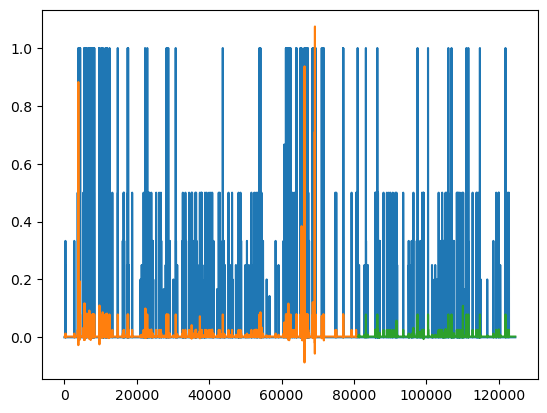

In [30]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [31]:
len(test_data)

43608

In [32]:
x_input=test_data[43508:].reshape(1,-1)
x_input.shape

(1, 100)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
temp_input

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [35]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.00259402]
101
1 day input [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.  

 0.00261944 0.00263712 0.00262127 0.00259359]
8 day output [[0.00258562]]
9 day input [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00259402 0.0026

 0.00266255 0.0026539  0.00264577 0.00264457]
16 day output [[0.00264915]]
17 day input [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00259402
 0.00260354 0.00258317 0.00258811 0.00261944 0.00263712 0.00262127
 0.00259359

 0.00266442 0.00266637 0.00266841 0.00267035]
24 day output [[0.00267215]]
25 day input [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00259402 0.00260354 0.00258317
 0.00258811 0.00261944 0.00263712 0.00262127 0.00259359 0.00258562
 0.00260595 0.00263796 0.00265968 0.00266255 0.0026539  0.00264577
 0.

In [36]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [37]:
import matplotlib.pyplot as plt

In [38]:
len(data)

124592

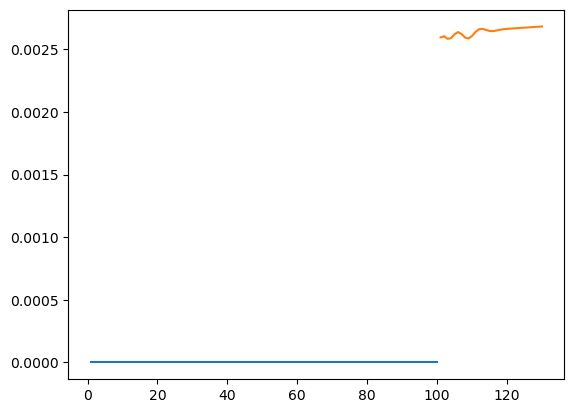

In [39]:
plt.plot(day_new,scaler.inverse_transform(data[124492:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [23]:
from time import gmtime, strftime
time = strftime("%Y-%m-%d-%H:%M:%S", gmtime())
model.savetf.keras.saving.load_model(f'../models/LSTM_credit {time}.keras')

AttributeError: module 'tensorflow.keras' has no attribute 'saving'